In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as  plt
from sklearn import tree                                                        

MENS = 'mens'
WOMENS = 'womens'
TEST = 'test'
TRAIN = 'train'

# Columns in Data With Categorical Values- Must LabelEncode them
categorical_cols = ['hitpoint', 'outside.sideline', 'outside.baseline', 'same.side', 
                    'previous.hitpoint', 'server.is.impact.player', 'outcome']

# Columns in the Data That Should Be Scaled
scaled_data = ['serve', 'rally', 'speed', 'net.clearance', 'distance.from.sideline', 'depth', 'player.distance.travelled', 
               'player.impact.depth', 'player.impact.distance.from.center', 'player.depth', 
               'player.distance.from.center', 'previous.speed', 'previous.net.clearance', 
               'previous.distance.from.sideline', 'previous.depth', 'opponent.depth', 
               'opponent.distance.from.center', 'previous.time.to.net']

In [3]:
# Load Data and Return pandas df
def load_tennis_data(gender, train='train'):
    assert gender == 'mens' or gender == 'womens'
    assert train == 'train' or train == 'test'
    csv_path = 'tennis_data/' + gender + '_' + train + '_file.csv'
    return pd.read_csv(csv_path)

# Return Shuffled Training Data- Reorder With ID as first column
def preprocess(data): 
    temp = data 
    temp = shuffle(temp, random_state=42)
    cols = temp.columns.tolist()
    new_cols = cols[-4:-3] + cols[0:-4]  + cols[-3:]
    temp = temp[new_cols]
    return temp

# Return ID Column
def get_id(data):
    return data['id']

# Return df with non-features dropped- ID, Gender, Train
def get_feature_cols(data):
    temp = data 
    temp.drop('id', 1, inplace=True)   
    temp.drop('gender', 1, inplace=True)
    temp.drop('train', 1, inplace=True)
    return temp

# Encode Categorical Data
def encode_data(data):
    temp = data
    # Retain All LabelEncoder as a dictionary
    d = defaultdict(LabelEncoder)

    # Encode all the columns
    temp[categorical_cols] = temp[categorical_cols].apply(lambda x: d[x.name].fit_transform(x))
#     print(d['outcome'].classes_)
    # Inverse the encoding
    # temp.apply(lambda x: d[x.name].inverse_transform(x))

    # Using dictionary d to label future data
    # mens_data[categorical_cols].apply(lambda x: d[x.name].transform(x))
    return temp

# Scale Data
def scale_data(data):
    temp = data
    scaler = MinMaxScaler()
    temp[scaled_data] = scaler.fit_transform(temp[scaled_data])
    return temp


# Create Model
def create_model():
    model = Sequential()
    model.add(Dense(15, input_dim=24, activation='relu', kernel_initializer='random_uniform'))
    model.add(Dropout(0.4))

    model.add(Dense(15, input_dim=24, activation='relu', kernel_initializer='lecun_uniform'))

#     model.add(Dense(15, input_dim=24, activation='relu', kernel_initializer='random_uniform'))
#     model.add(Dropout(0.4))
#     model.add(Dense(15, input_dim=24, activation='relu', kernel_initializer='random_uniform'))
# #     model.add(Dropout(0.4))
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.add(Dense(3, activation='softmax', kernel_initializer='lecun_uniform'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

    
# Build and Train Model
def train_and_evaluate_model(model, x_train, y_train, xval, yval, epochs, batch_size):
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                         validation_data=(xval, yval))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return model

# Use model to predict
def prediction(model, data):  
    return model.predict(data)

# Return Train X, Train Y, Val X, Val Y, ID Columns
def split_train_validation_data(gender, test_size=0.2, random_state=None):
    train_data = load_tennis_data(gender, TRAIN)
    train_data= preprocess(train_data)
    train_id = get_id(train_data)
    train_data = get_feature_cols(train_data)
    train_data = encode_data(train_data)
    train_data = scale_data(train_data)
    # mens_train_data.head()

    # Split into training and validation sets
    train_mens, val_mens = train_test_split(train_data, test_size=test_size, random_state=random_state)

    # Split data into input and outputs
    X_train = train_mens.loc[:, train_mens.columns != 'outcome']
    Y_train = train_mens['outcome']
    X_val = val_mens.loc[:, val_mens.columns != 'outcome']
    Y_val = val_mens['outcome']
    

    # Reshape Data To Put Into NN
    X_train_np = X_train.values.reshape((-1, 24))
    Y_train_np = Y_train.reshape((-1,1))
    X_val_np = X_val.values.reshape((-1, 24))
    Y_val_np = Y_val.reshape((-1,1))
    return X_train_np, Y_train_np, X_val_np, Y_val_np, train_id

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 1s 152us/step - loss: 1.0594 - acc: 0.4252 - val_loss: 0.9911 - val_acc: 0.5080
Epoch 2/100
4000/4000 [==============================] - 0s 75us/step - loss: 0.9357 - acc: 0.5635 - val_loss: 0.8062 - val_acc: 0.6860
Epoch 3/100
4000/4000 [==============================] - 0s 74us/step - loss: 0.7850 - acc: 0.6645 - val_loss: 0.6715 - val_acc: 0.7520
Epoch 4/100
4000/4000 [==============================] - 0s 66us/step - loss: 0.6969 - acc: 0.7085 - val_loss: 0.6097 - val_acc: 0.7770
Epoch 5/100
4000/4000 [==============================] - 0s 59us/step - loss: 0.6522 - acc: 0.7398 - val_loss: 0.5709 - val_acc: 0.7790
Epoch 6/100
4000/4000 [==============================] - 0s 58us/step - loss: 0.6224 - acc: 0.7435 - val_loss: 0.5700 - val_acc: 0.7840
Epoch 7/100
4000/4000 [==============================] - 0s 78us/step - loss: 0.6039 - acc: 0.7592 - val_loss: 0.5482 - val_acc: 0.7890

4000/4000 [==============================] - 0s 52us/step - loss: 0.4884 - acc: 0.8155 - val_loss: 0.4498 - val_acc: 0.8270
Epoch 61/100
4000/4000 [==============================] - 0s 52us/step - loss: 0.4699 - acc: 0.8177 - val_loss: 0.4393 - val_acc: 0.8260
Epoch 62/100
4000/4000 [==============================] - 0s 59us/step - loss: 0.4700 - acc: 0.8227 - val_loss: 0.4368 - val_acc: 0.8340
Epoch 63/100
4000/4000 [==============================] - 0s 64us/step - loss: 0.4798 - acc: 0.8157 - val_loss: 0.4418 - val_acc: 0.8240
Epoch 64/100
4000/4000 [==============================] - 0s 67us/step - loss: 0.4712 - acc: 0.8175 - val_loss: 0.4421 - val_acc: 0.8240
Epoch 65/100
4000/4000 [==============================] - 0s 50us/step - loss: 0.4751 - acc: 0.8147 - val_loss: 0.4413 - val_acc: 0.8250
Epoch 66/100
4000/4000 [==============================] - 0s 50us/step - loss: 0.4782 - acc: 0.8143 - val_loss: 0.4404 - val_acc: 0.8250
Epoch 67/100
4000/4000 [==============================

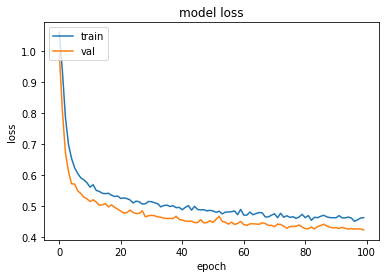

In [4]:
# Men's Model
X_train_m, Y_train_m, X_val_m, Y_val_m, train_id_m = split_train_validation_data(MENS, 0.2, random_state=42)

model_m = create_model()
model_m = train_and_evaluate_model(model_m, X_train_m, Y_train_m, X_val_m, Y_val_m, epochs=100, batch_size=32)

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 1s 262us/step - loss: 1.0570 - acc: 0.4365 - val_loss: 1.0043 - val_acc: 0.5830
Epoch 2/100
4000/4000 [==============================] - 0s 76us/step - loss: 0.9213 - acc: 0.6210 - val_loss: 0.8239 - val_acc: 0.6550
Epoch 3/100
4000/4000 [==============================] - 0s 69us/step - loss: 0.7716 - acc: 0.6647 - val_loss: 0.6949 - val_acc: 0.6710
Epoch 4/100
4000/4000 [==============================] - 0s 79us/step - loss: 0.6943 - acc: 0.6833 - val_loss: 0.6500 - val_acc: 0.6780
Epoch 5/100
4000/4000 [==============================] - 0s 81us/step - loss: 0.6601 - acc: 0.7005 - val_loss: 0.6220 - val_acc: 0.6870
Epoch 6/100
4000/4000 [==============================] - 0s 80us/step - loss: 0.6353 - acc: 0.7215 - val_loss: 0.5982 - val_acc: 0.7060
Epoch 7/100
4000/4000 [==============================] - 0s 81us/step - loss: 0.6212 - acc: 0.7343 - val_loss: 0.5817 - val_acc: 0.7410

4000/4000 [==============================] - 0s 76us/step - loss: 0.5115 - acc: 0.8045 - val_loss: 0.4724 - val_acc: 0.8140
Epoch 61/100
4000/4000 [==============================] - 0s 68us/step - loss: 0.5073 - acc: 0.8043 - val_loss: 0.4757 - val_acc: 0.8050
Epoch 62/100
4000/4000 [==============================] - 0s 62us/step - loss: 0.5001 - acc: 0.8075 - val_loss: 0.4693 - val_acc: 0.8130
Epoch 63/100
4000/4000 [==============================] - 0s 68us/step - loss: 0.5037 - acc: 0.8035 - val_loss: 0.4738 - val_acc: 0.8040
Epoch 64/100
4000/4000 [==============================] - 0s 71us/step - loss: 0.5080 - acc: 0.8047 - val_loss: 0.4756 - val_acc: 0.7990
Epoch 65/100
4000/4000 [==============================] - 0s 69us/step - loss: 0.5085 - acc: 0.8050 - val_loss: 0.4726 - val_acc: 0.8030
Epoch 66/100
4000/4000 [==============================] - 0s 61us/step - loss: 0.5029 - acc: 0.8043 - val_loss: 0.4835 - val_acc: 0.7950
Epoch 67/100
4000/4000 [==============================

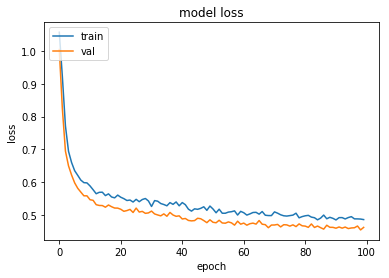

In [56]:
# Women's Model
X_train_w, Y_train_w, X_val_w, Y_val_w, train_id_w = split_train_validation_data(WOMENS, 0.2, 42)
model_w = create_model()
model_w = train_and_evaluate_model(model_w, X_train_w, Y_train_w, X_val_w, Y_val_w, epochs=100, batch_size=32)

In [13]:
def create_result_file():
    csv_path = 'tennis_data/AUS_SubmissionFormat.csv'
    return pd.read_csv(csv_path)

    
def append_gender(data, gender):
    return str(data) + '_' + str(gender)

def create_column_ids(mens_id, womens_id):
    mens_test_id_col = mens_id.apply(append_gender, args=('mens',))
    womens_test_id_col = womens_id.apply(append_gender, args=('womens',))

    combined_id = np.concatenate((mens_test_id_col, womens_test_id_col))
    
    return pd.DataFrame(combined_id)

def preprocess_test(gender): 
    data = load_tennis_data(gender, TEST)
    data= preprocess(data)
    # print(mens_test_data.head())
    ids = get_id(data)
    # print(mens_test_id.head())
    data = get_feature_cols(data)
    data = encode_data(data)
    data = scale_data(data)
    data = data.loc[:, data.columns != 'outcome']
    data = data.values.reshape((-1, 24))
    return data, ids

# Preprocess Men's Test Data
test_data_m, test_id_m = preprocess_test(MENS)
# Preprocess Women's Test Data
test_data_w, test_id_w = preprocess_test(WOMENS)
# Create IDs
column_ids = create_column_ids(test_id_m, test_id_w)

In [57]:
print(test_data_m)

[[ 0.          0.          1.         ...,  0.          0.44953998  1.        ]
 [ 0.04        0.          0.         ...,  1.          0.16175605  0.        ]
 [ 0.          0.          1.         ...,  0.          0.23609163  1.        ]
 ..., 
 [ 0.2         1.          1.         ...,  0.          0.21890853  0.        ]
 [ 0.08        0.          1.         ...,  3.          0.50676933  1.        ]
 [ 0.52        1.          0.         ...,  1.          0.14626556  0.        ]]


In [58]:
# PREDICTION
m_prediction = prediction(model_m, test_data_m)
m_prediction = pd.DataFrame(m_prediction)
m_prediction.head()

,0,1,2
0,0.008658,0.456439,0.534903
1,0.961686,0.035974,0.002340
2,0.216943,0.780723,0.002333
3,0.038312,0.961163,0.000525
4,0.224365,0.729319,0.046317


In [16]:
w_prediction = prediction(model_w, test_data_w)
w_prediction = pd.DataFrame(w_prediction)
w_prediction.tail()

,0,1,2
995,0.555004,0.262014,0.182982
996,0.012993,0.295786,0.691221
997,0.250543,0.748489,0.000968
998,0.008360,0.884129,0.107511
999,0.000070,0.016769,0.983161


In [17]:
combined_test_predictions = pd.concat([m_prediction, w_prediction], axis=0)
combined_test_predictions.columns = ['FE', 'UE', 'W']
combined_test_predictions.reset_index(inplace=True, drop=True)
combined_test_predictions.head()

,FE,UE,W
0,0.005122,0.554814,0.440064
1,0.976242,0.019685,0.004074
2,0.155962,0.842100,0.001939
3,0.011871,0.987998,0.000131
4,0.146630,0.821543,0.031828


In [18]:
def format_submission(predictions):
    format_file = create_result_file()
#     format_file['submission_id']
    # result = create_column_ids(mens_test_id, womens_test_id, result)
    final = pd.concat([column_ids, format_file[['train']], predictions], axis=1, )
    final.columns = ['submission_id', 'train', 'FE', 'UE', 'W']
    final = final.set_index(list(final[['submission_id']])).T
    correct_order = list(format_file['submission_id'])
    final_sorted = final[correct_order].T.reset_index()

    # # final[['4314_mens']]
    # # list(result['submission_id'])

    # # final[list(column_ids)]
    # # list(result['submission_id'])
    # # pd.DataFrame(data=final.values, index= list(result['submission_id']))
    # # final.rein dex(list(result['submission_id']))
    # # # # # final = result[['submission_id', 'train']].append(combined_test_predictions)
    # final_sorted

    cols = ['submission_id', 'train', 'UE', 'FE', 'W']
    final_sorted = final_sorted[cols]
    return final_sorted

In [20]:
final_submission = format_submission(combined_test_predictions)
final_submission.head()

,submission_id,train,UE,FE,W
0,4314_mens,0.0,0.999863,0.000057,0.000080
1,3559_mens,0.0,0.280467,0.712843,0.006690
2,768_mens,0.0,0.891903,0.102359,0.005738
3,426_mens,0.0,0.343095,0.647667,0.009238
4,807_mens,0.0,0.900060,0.099820,0.000121


In [23]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
def save_file(data):
    data.to_csv('Submissions/SubmissionNN' + timestr + '.csv', index=False)
save_file(final_submission)